In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt 
import albumentations as alb
import os 
import time
import uuid
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense , GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model

In [2]:
image_path = os.path.join('data' ,  'images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range (number_images) :
    print(f'collecting image: {imgnum}')
    ret ,frame = cap.read()
    imgname = os.path.join(image_path , f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname , frame)
    cv2.imshow('frame' , frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
    

collecting image: 0
collecting image: 1
collecting image: 2
collecting image: 3
collecting image: 4
collecting image: 5
collecting image: 6
collecting image: 7
collecting image: 8
collecting image: 9
collecting image: 10
collecting image: 11


In [4]:
!labelme

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
    tf.config.experimental.set_memory_growth(gpu , True)

In [17]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [18]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle= False)

In [30]:
images.as_numpy_iterator().next()

b'data\\images\\02a661fc-723d-11ee-8ad4-40ec99cd4267.jpg'

In [2]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img= tf.io.decode_jpeg(byte_img)
    return img
    

In [32]:
images = images.map(load_image)

In [34]:
images.as_numpy_iterator().next()

array([[[198, 174, 174],
        [199, 175, 175],
        [199, 178, 175],
        ...,
        [140, 127, 121],
        [140, 126, 123],
        [140, 126, 123]],

       [[200, 176, 176],
        [200, 176, 176],
        [201, 177, 175],
        ...,
        [140, 127, 121],
        [141, 127, 124],
        [141, 127, 124]],

       [[201, 175, 176],
        [199, 175, 175],
        [199, 175, 173],
        ...,
        [141, 127, 124],
        [141, 127, 124],
        [141, 127, 124]],

       ...,

       [[188, 176, 180],
        [188, 176, 180],
        [188, 176, 180],
        ...,
        [ 16,  14,  17],
        [ 15,  14,  19],
        [ 15,  15,  17]],

       [[188, 176, 180],
        [188, 176, 180],
        [187, 176, 180],
        ...,
        [ 15,  14,  19],
        [ 15,  14,  20],
        [ 15,  14,  19]],

       [[187, 175, 179],
        [188, 176, 180],
        [187, 176, 180],
        ...,
        [ 15,  14,  20],
        [ 16,  15,  21],
        [ 16,  15,  21]]

In [35]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [36]:
image_generator = images.batch(4).as_numpy_iterator()

In [53]:
plot_images = image_generator.next()

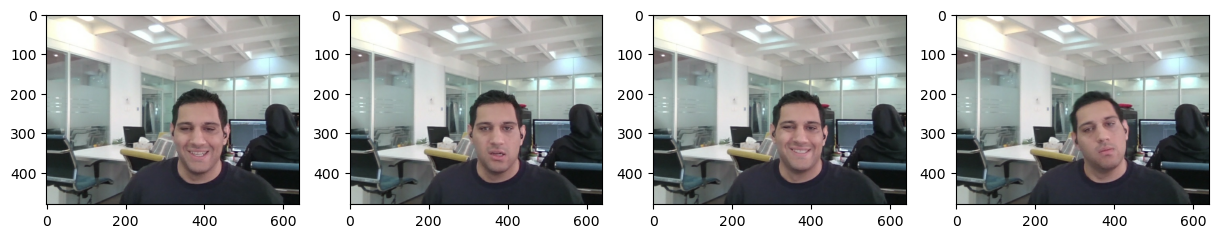

In [57]:
fig , ax = plt.subplots(ncols=4 , figsize =(15,15))
for idx , image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

#  MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [62]:
# 95 images>> split 63 to train and 16 images to val and test(build folders manually)
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

In [40]:
augmentor = alb.Compose([alb.RandomCrop(width=450 , height= 450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p= 0.2),
                        alb.RGBShift(p = 0.5)],
                       bbox_params=alb.BboxParams(format= 'albumentations' ,
                                                 label_fields=['class_labels']))

In [42]:
img = cv2.imread(os.path.join('data' , 'train' , 'images' , '02a661fc-723d-11ee-8ad4-40ec99cd4267.jpg'))

In [44]:
img.shape

(480, 640, 3)

In [45]:
with open(os.path.join('data' , 'train' , 'labels' , '02a661fc-723d-11ee-8ad4-40ec99cd4267.json') , 'r') as f :
    label = json.load(f)

In [46]:
label['shapes'][0]['points']

[[257.81094527363183, 195.22388059701493],
 [429.95024875621885, 430.0497512437811]]

In [47]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [48]:
coords

[257.81094527363183, 195.22388059701493, 429.95024875621885, 430.0497512437811]

In [49]:
coords = list(np.divide(coords ,[640, 480 ,640, 480]))

In [50]:
augmented = augmentor(image = img , bboxes = [coords] , class_labels = ['face'])

In [15]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

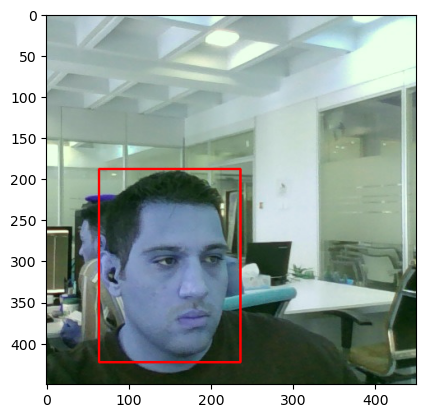

In [17]:
cv2.rectangle(augmented['image'] ,
             tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
             (255,0,0) , 2)
plt.imshow(augmented['image'])


# Run Augmentation Pipeline

In [5]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
                
                
                
                
                
                
                
                
                

x_max is less than or equal to x_min for bbox [0.263681592039801, 0.5891376451077943, 0.00948383084577118, 0.9902570480928689, 'face'].
x_max is less than or equal to x_min for bbox [0.20537935323383089, 0.6347429519071309, 0.011038557213930388, 0.98818407960199, 'face'].
x_max is less than or equal to x_min for bbox [0.1455223880597015, 0.6813847429519072, 0.004042288557213958, 0.9695273631840796, 'face'].
x_max is less than or equal to x_min for bbox [0.18050373134328362, 0.6585820895522387, 0.004819651741293574, 0.9653814262023217, 'face'].
x_max is less than or equal to x_min for bbox [0.1082089552238806, 0.7176616915422885, 0.0032649253731343642, 0.9363598673300166, 'face'].
x_max is less than or equal to x_min for bbox [0.20537935323383089, 0.6274875621890548, 0.0, 0.9498943959448044, 'face'].
x_max is less than or equal to x_min for bbox [0.16184701492537315, 0.6627280265339967, 0.0, 0.9401800521203507, 'face'].


# Load Augmented Images to Tensorflow Dataset

In [3]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [4]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [5]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [6]:
train_images.as_numpy_iterator().next()

array([[[0.7644608 , 0.68063724, 0.6811274 ],
        [0.8315564 , 0.74626225, 0.7472426 ],
        [0.8976716 , 0.80355394, 0.80355394],
        ...,
        [0.5957721 , 0.5487132 , 0.5536152 ],
        [0.5869485 , 0.5248774 , 0.5335172 ],
        [0.59552693, 0.5226716 , 0.53180146]],

       [[0.79264706, 0.70490193, 0.71666664],
        [0.7749387 , 0.6859069 , 0.6946691 ],
        [0.77432597, 0.6802083 , 0.6802083 ],
        ...,
        [0.60925245, 0.5626838 , 0.56170344],
        [0.596201  , 0.54362744, 0.54264706],
        [0.59479165, 0.5356005 , 0.5372549 ]],

       [[0.8137255 , 0.7151961 , 0.69754905],
        [0.80735296, 0.7088235 , 0.69460785],
        [0.7939951 , 0.6990196 , 0.6985907 ],
        ...,
        [0.62781864, 0.5729167 , 0.5689951 ],
        [0.6161152 , 0.57297796, 0.5651348 ],
        [0.60275733, 0.5596201 , 0.55177695]],

       ...,

       [[0.178125  , 0.19381127, 0.19773284],
        [0.17506127, 0.17898284, 0.18780637],
        [0.15735294, 0

In [6]:
def load_labels(label_path):
    with open (label_path.numpy() , 'r' , encoding='utf-8') as f :
        label = json.load(f)
    return [label['class']] , label['bbox']

In [7]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json' , shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x] , [tf.uint8 , tf.float16]))

In [8]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [9]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [15]:
test_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.1805, 0.313 , 0.6616, 0.9077], dtype=float16))

# Combine Label and Image Samples

In [16]:
len(train_images) , len(train_labels) , len(test_images) , len(test_labels) , len(val_images) , len(val_labels)

(3480, 3480, 900, 900, 840, 840)

In [10]:
train = tf.data.Dataset.zip((train_images , train_labels))
train = train.shuffle(4000)
train = train.batch(8)
train = train.prefetch(4)

In [11]:
test = tf.data.Dataset.zip((test_images , test_labels))
test = test.shuffle(1000)
test = test.batch(8)
test = test.prefetch(4)

In [12]:
val = tf.data.Dataset.zip((val_images , val_labels))
val = val.shuffle(900)
val = val.batch(8)
val = val.prefetch(4)

In [16]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.2267, 0.4512, 0.5376, 0.868 ],
        [0.565 , 0.4856, 0.8843, 0.8716],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.1796, 0.2556, 0.592 , 0.8096],
        [0.3667, 0.4756, 0.6587, 0.8867],
        [0.3667, 0.2467, 0.812 , 0.8594]], dtype=float16))

# View Images and Annotations

In [17]:
data_samples = train.as_numpy_iterator()

In [18]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


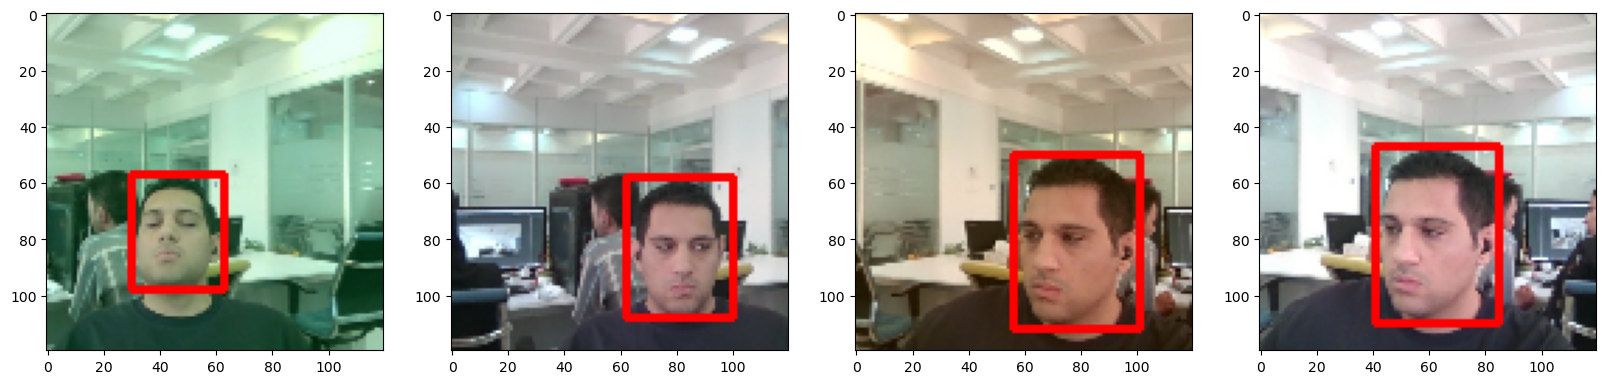

In [19]:
fig , ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx in range(4) :
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image , 
                 tuple(np.multiply(sample_coords[:2] , [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:] , [120,120]).astype(int)),
                  (255,0,0) , 2)
    
    ax[idx].imshow(sample_image)
    
                

# Build Deep Learning using the Functional API

In [21]:
vgg = VGG16(include_top=False)

In [22]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [17]:
def build_model():
    input_layer = Input(shape = (120,120,3))
    vgg = VGG16(include_top= False)(input_layer)
    
    #classification model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048 , activation= 'relu')(f1)
    class2 = Dense(1 , activation= 'sigmoid')(class1)
    
    #boundig box model
    f2 = GlobalMaxPooling2D()(vgg)
    reg1 = Dense(2048 , activation= 'relu')(f2)
    reg2 = Dense(4 , activation= 'sigmoid')(reg1)
    
    facetracker = Model(inputs = input_layer , outputs = [class2 , reg2])
    return facetracker

In [18]:
facetracker = build_model()

In [19]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 120, 120, 3) 0                                            
__________________________________________________________________________________________________
vgg16 (Functional)              (None, None, None, 5 14714688    input_1[0][0]                    
__________________________________________________________________________________________________
global_max_pooling2d (GlobalMax (None, 512)          0           vgg16[0][0]                      
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           vgg16[0][0]                      
______________________________________________________________________________________________

# Define Losses and Optimizers

In [20]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate= 0.0001 , decay = lr_decay)

In [22]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [23]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

# Create Custom Model Class

In [24]:
class FaceTracker(Model) :
    def __init__ (self , facetracker , **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
        
    def compile(self, opt, classloss , localizationloss , **kwargs):
        super().compile(**kwargs)
        self.closs= classloss
        self.lloss = localizationloss
        self.opt = opt
        
    def train_step(self , batch , **kwargs):
        
        X, y = batch
        
        with tf.GradientTape() as tape :
            classes, coords = self.model(X , training = True)
            
            batch_classloss = self.closs(y[0] , classes)
            batch_localizationloss = self.lloss(tf.cast(y[1] , tf.float32) , coords)
            
            total_loss = batch_localizationloss + 0.5*batch_classloss
            
            grad = tape.gradient(total_loss , self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad , self.model.trainable_variables))
        
        return {'total_loss' : total_loss , 'class_loss' : batch_classloss , 'regress_loss' : batch_localizationloss}
    
    def test_step (self, batch , **kwargs):
        X,y = batch
        
        classes , coords = self.model(X , training = False)
        
        batch_classloss = self.closs(y[0] , classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32) , coords)
        total_loss = batch_localizationloss + 0.5*batch_classloss
        
        return {'total_loss' : total_loss , 'class_loss' : batch_classloss , 'regress_loss' : batch_localizationloss}
    
    def call(self, X , **kwargs):
        return self.model(X,**kwargs)

In [25]:
model = FaceTracker(facetracker)

In [26]:
model.compile(opt, classloss, regressloss)

In [27]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [28]:
hist = model.fit(train , epochs=40 , validation_data=val , callbacks=[tensorboard_callback] )

Epoch 1/40
435/435 [==============================] - 83s 161ms/step - total_loss: 0.2553 - class_loss: 0.0616 - regress_loss: 0.2245 - val_total_loss: 0.1998 - val_class_loss: 0.0446 - val_regress_loss: 0.1775
Epoch 2/40
435/435 [==============================] - 72s 147ms/step - total_loss: 0.0601 - class_loss: 0.0169 - regress_loss: 0.0517 - val_total_loss: 0.1895 - val_class_loss: 0.0777 - val_regress_loss: 0.1507
Epoch 3/40
435/435 [==============================] - 68s 145ms/step - total_loss: 0.0207 - class_loss: 0.0046 - regress_loss: 0.0184 - val_total_loss: 0.0235 - val_class_loss: 6.5986e-05 - val_regress_loss: 0.0234
Epoch 4/40
435/435 [==============================] - 67s 145ms/step - total_loss: 0.0088 - class_loss: 0.0014 - regress_loss: 0.0081 - val_total_loss: 0.0168 - val_class_loss: 0.0017 - val_regress_loss: 0.0160
Epoch 5/40
435/435 [==============================] - 68s 145ms/step - total_loss: 0.0077 - class_loss: 0.0014 - regress_loss: 0.0070 - val_total_loss: 

# Plot Performance

In [29]:
hist.history

{'total_loss': [0.06945935636758804,
  0.03902621194720268,
  0.01783321239054203,
  0.003843805519863963,
  0.004771391861140728,
  0.005919845774769783,
  0.017725668847560883,
  0.00402077566832304,
  0.0023208600468933582,
  0.0020490936003625393,
  0.0017999481642618775,
  0.0017220611916854978,
  0.00214203423820436,
  0.0014951276825740933,
  0.0016803140752017498,
  0.001285515958443284,
  0.0016267141327261925,
  0.0015206701355054975,
  0.001223352155648172,
  0.000522953923791647,
  0.0005181329906918108,
  0.000821489084046334,
  0.0020220770966261625,
  0.0012811182532459497,
  0.00039491147617809474,
  0.0005977533874101937,
  0.0005122648435644805,
  0.0005935453809797764,
  0.0009017487755045295,
  0.0003921033930964768,
  0.00040026201168075204,
  0.00045336291077546775,
  0.0007099492358975112,
  0.0004689485067501664,
  0.00014276652655098587,
  0.000539228436537087,
  0.00028011552058160305,
  0.000568834540899843,
  0.00027850689366459846,
  0.0002676238655112684],

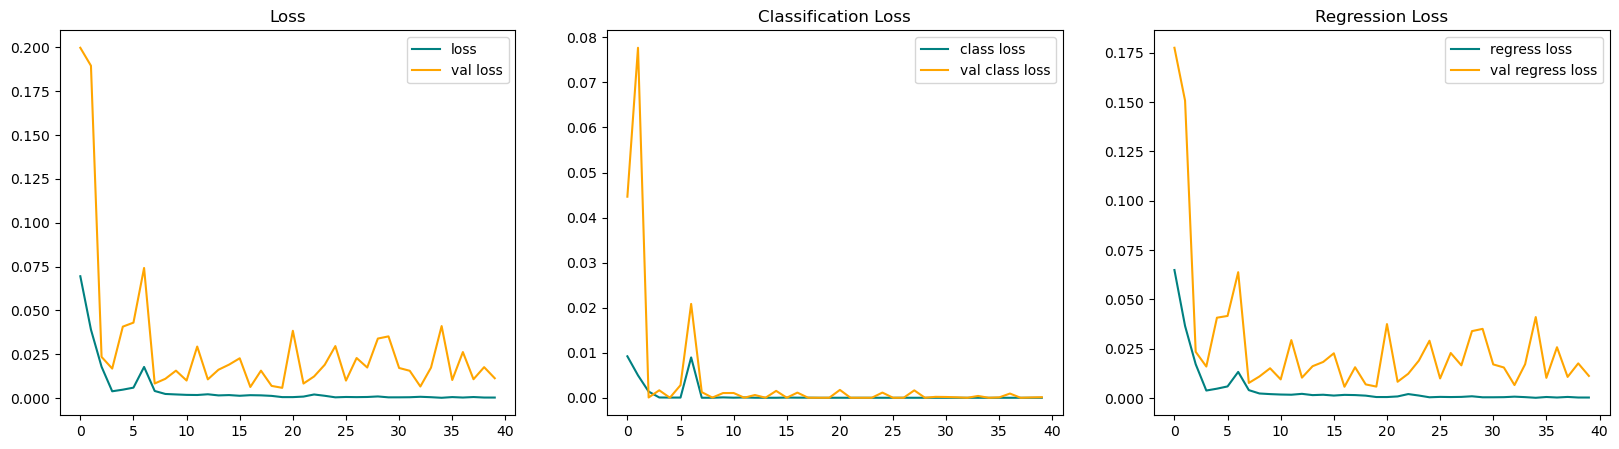

In [31]:
fig , ax = plt.subplots(ncols = 3 , figsize =(20 ,5))

ax[0].plot(hist.history['total_loss'] , color = 'teal' , label = 'loss')
ax[0].plot(hist.history['val_total_loss'] , color = 'orange' , label = 'val loss')
ax[0].title.set_text('Loss')
ax[0].legend()


ax[1].plot(hist.history['class_loss'] , color = 'teal' , label = 'class loss')
ax[1].plot(hist.history['val_class_loss'] , color = 'orange' , label = 'val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()


ax[2].plot(hist.history['regress_loss'] , color = 'teal' , label = 'regress loss')
ax[2].plot(hist.history['val_regress_loss'] , color = 'orange' , label = 'val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()



# Make Predictions

In [36]:
test_data = test.as_numpy_iterator()

In [37]:
test_sample =test_data.next()

In [38]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


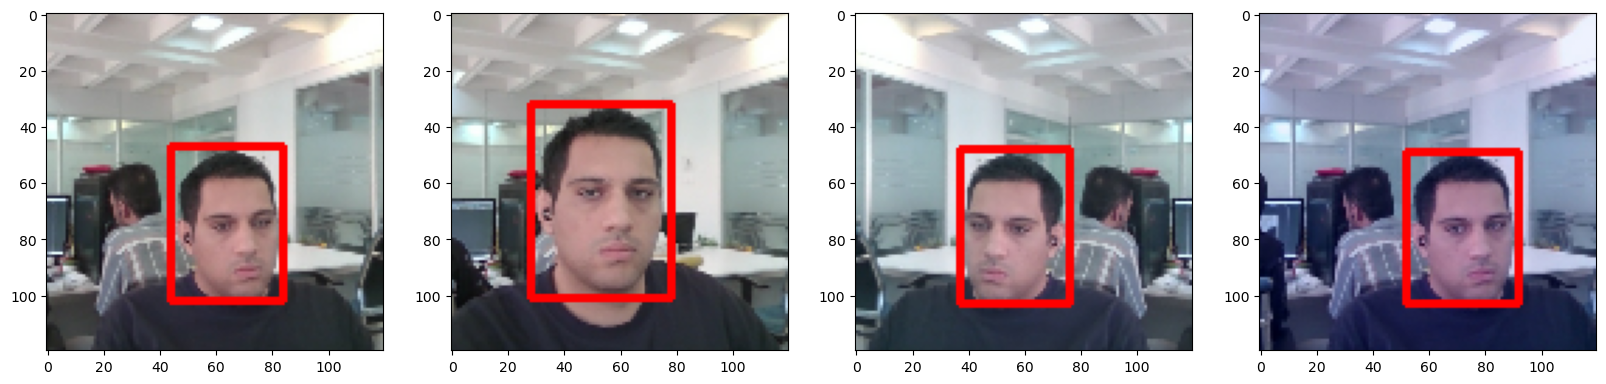

In [39]:
fig , ax = plt.subplots(ncols=4 , figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.5 :
        cv2.rectangle(sample_image,
                     tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                     tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)),
                     (255,0,0) , 2)
    ax[idx].imshow(sample_image)

In [75]:
model.summary()

Model: "face_tracker"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           [(None, 1), (None, 4)]    16826181  
Total params: 16,826,181
Trainable params: 16,826,181
Non-trainable params: 0
_________________________________________________________________


 # Save the Model

In [71]:
facetracker.save('facetracker.h5')

In [16]:
facetracker = load_model('facetracker.h5')

 # Real Time Detection

In [4]:
cap =cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500 , 50:500 , :]
    
    rgb = cv2.cvtColor(frame , cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb , (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5 :
        cv2.rectangle(frame , 
                     tuple(np.multiply(sample_coords[:2] , [450,450]).astype(int)),
                     tuple(np.multiply(sample_coords[2:] , [450,450]).astype(int)),
                     (255,0,0) ,2)
        
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                   [80,0])),
                      (255,0,0),-1)
        
        cv2.putText(frame, 'face' , tuple(np.add(np.multiply(sample_coords[:2] , [450,450]).astype(int),
                                                [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX , 1 ,(255,255,255) ,2 , cv2.LINE_AA)
        
        cv2.imshow('Facetrack' , frame)
        
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()   